# All Weather Live Portfolio Tracker (OOP Version)

**Strategy**: v1.2 (Adaptive Rebalancing + Ledoit-Wolf Shrinkage)  
**Rebalance Frequency**: Weekly check (rebalance when drift > 5%)  
**Commission**: 0.03% one-side

---

## Key Features:
- **OOP Design**: Clean `Portfolio` class with automatic PnL tracking
- **Auto Data Fetch**: Prices auto-load from Yahoo Finance (yfinance)
- **Risk Parity**: Automatic target weight calculation using Ledoit-Wolf shrinkage
- **Rebalancing Signals**: Alerts when drift > 5%
- **Performance Analytics**: Comprehensive metrics (Sharpe, Sortino, max DD, etc.)
- **Trade Logging**: Full history with realized PnL tracking

---

## Quick Start:
1. **Edit Cell 3**: Define ETFs, initial cash, and build positions with `trade()` method
2. **Run all cells**: View positions, rebalancing needs, PnL, and analytics
3. **Check "Rebalancing Analysis"**: See if trades are needed
4. **View PnL Curve**: Track performance from entry to current date
5. **After trading**: Add new trades, rerun notebook

**Important**: 
- All ETFs trade in **100-share lots** (rounded automatically)
- Data fetched live from **Yahoo Finance** via yfinance
- Falls back to local data if Yahoo Finance unavailable
- Commission: **0.03%** one-side
- PnL tracking updates automatically to latest available data

In [8]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from src.portfolio_tracker import Portfolio
from src.utils.reporting import print_section, format_currency

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Imports successful")

✓ Imports successful


## 1. Portfolio Initialization

**EDIT THE NEXT CELL** to:
- Define your tradable ETFs
- Set initial cash
- Build positions using `portfolio.trade()` method

The Portfolio class will:
- Auto-fetch live prices from yfinance (with fallback to local data)
- Track PnL automatically from first trade date
- Calculate risk parity target weights
- Generate rebalancing signals when drift > 5%

In [9]:
# ========== EDIT YOUR PORTFOLIO HERE ==========
# Define the 6 ETFs to track
TRADABLE_ETFS = [
    '510300.SH',  # CSI 300 - Large cap stocks
    '510500.SH',  # CSI 500 - Mid/small cap stocks  
    '513500.SH',  # S&P 500
    '511260.SH',  # 10Y Treasury (trades in 100s)
    '518880.SH',  # Gold
    '513100.SH'   # Nasdaq-100
]

# Initialize portfolio with initial cash
portfolio = Portfolio(
    tradable_etfs=TRADABLE_ETFS,
    initial_cash=30000,  # Starting cash before trades
    commission_rate=0.0003,  # 0.03%
    rebalance_threshold=0.05,  # 5% drift
    lookback=252  # 252-day lookback for risk parity
)

# Build initial positions with trade() method
# Entry date: 2026-01-30
portfolio.trade(qty=700, price=4.681, side='buy', day='2026-01-30', etf='510300.SH')
portfolio.trade(qty=300, price=8.364, side='buy', day='2026-01-30', etf='510500.SH')
portfolio.trade(qty=1100, price=2.404, side='buy', day='2026-01-30', etf='513500.SH')
portfolio.trade(qty=100, price=135.096, side='buy', day='2026-01-30', etf='511260.SH')
portfolio.trade(qty=300, price=10.686, side='buy', day='2026-01-30', etf='518880.SH')
portfolio.trade(qty=1100, price=1.843, side='buy', day='2026-01-30', etf='513100.SH')
# ======================================================

print_section("Portfolio Initialized")
print(f"\nTradable ETFs: {len(TRADABLE_ETFS)}")
print(f"Initial trades executed: {len(portfolio.log)}")
print(f"\nCurrent cash: {format_currency(portfolio._cash)}")
print(f"Total value: {format_currency(portfolio.calc_value())}")


PORTFOLIO INITIALIZED

Tradable ETFs: 6
Initial trades executed: 6

Current cash: ¥2,819
Total value: ¥30,089


## 2. Current Positions

View current holdings with entry prices, market values, and unrealized PnL.

In [10]:
# Display current positions
positions_df = portfolio.positions

print_section("Current Positions")
print(f"\nTotal Portfolio Value: {format_currency(portfolio.calc_value())}")
print(f"Cash: {format_currency(portfolio._cash)}")
print()

# Format and display positions table
if not positions_df.empty:
    print(positions_df.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))
else:
    print("No positions")


CURRENT POSITIONS

Total Portfolio Value: ¥30,089
Cash: ¥2,819

      ETF  Shares  Entry Price  Current Price  Market Value  Unrealized PnL  Unrealized PnL %  Weight %
510300.SH     700         4.68           4.73      3,308.90           32.20              0.98     11.00
510500.SH     300         8.36           8.51      2,553.00           43.80              1.75      8.48
513500.SH    1100         2.40           2.40      2,636.70           -7.70             -0.29      8.76
511260.SH     100       135.10         135.26     13,526.20           16.60              0.12     44.95
518880.SH     300        10.69          10.74      3,222.60           16.80              0.52     10.71
513100.SH    1100         1.84           1.84      2,022.90           -4.40             -0.22      6.72


## 3. Rebalancing Signal

Check if portfolio needs rebalancing based on risk parity target weights.

In [11]:
# Get rebalancing signal
signal = portfolio.signal

print_section("Rebalancing Analysis")
print(f"\nCurrent Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nMaximum drift: {signal['drift']:.2%}")
print(f"Rebalance threshold: {signal['threshold']:.2%}")
print(f"\nNeeds rebalancing: {'YES ✓' if signal['should_rebalance'] else 'NO - within threshold'}")

# Show weight comparison
print("\nWeight Comparison:")
print(f"{'ETF':<15} {'Current':>10} {'Target':>10} {'Difference':>12}")
print("=" * 50)
for etf in TRADABLE_ETFS:
    current_w = signal['current_weights'][etf]
    target_w = signal['target_weights'][etf]
    diff = current_w - target_w
    print(f"{etf:<15} {current_w:>9.2%} {target_w:>9.2%} {diff:>+11.2%}")

# Show required trades if rebalancing needed
if signal['should_rebalance']:
    trades_needed = signal.get('trades_needed', [])
    if trades_needed:
        print("\n" + "="*70)
        print("REQUIRED TRADES")
        print("="*70)
        
        total_commission = 0
        total_trade_value = 0
        
        for trade in trades_needed:
            print(f"\n{trade['etf']}:")
            print(f"  Current: {trade['current_shares']:,.0f} shares")
            print(f"  Target:  {trade['target_shares']:,.0f} shares")
            print(f"  Action:  {trade['action']} {trade['shares']:,.0f} shares @ ¥{trade['price']:.4f}")
            
            trade_value = trade['shares'] * trade['price']
            commission = trade_value * portfolio._commission_rate
            
            print(f"  Value:   {format_currency(trade_value)}")
            print(f"  Commission: {format_currency(commission)}")
            
            total_commission += commission
            total_trade_value += trade_value
        
        print(f"\nTotal Trade Value: {format_currency(total_trade_value)}")
        print(f"Total Commission: {format_currency(total_commission)} ({total_commission/total_trade_value*100:.3f}%)")
else:
    print("\n✓ Portfolio is within drift threshold. No action needed.")


REBALANCING ANALYSIS

Current Time: 2026-02-11 21:29:32

Maximum drift: 2.58%
Rebalance threshold: 5.00%

Needs rebalancing: NO - within threshold

Weight Comparison:
ETF                Current     Target   Difference
510300.SH          11.00%    13.58%      -2.58%
510500.SH           8.48%     9.94%      -1.45%
513500.SH           8.76%    10.33%      -1.57%
511260.SH          44.95%    45.35%      -0.40%
518880.SH          10.71%    11.70%      -0.98%
513100.SH           6.72%     9.11%      -2.38%

✓ Portfolio is within drift threshold. No action needed.


## 4. PnL Tracking & Visualization

Track performance from entry date to current date (trading days only).


PNL SUMMARY

Entry Date: 2026-01-30
Latest Data: 2026-02-12
Days tracked: 9

Total PnL: ¥-93 (-0.31%)

Best day: ¥0 (+0.00%) on 2026-01-30
Worst day: ¥-660 (-2.19%) on 2026-02-02

Recent PnL:
               PnL  PnL %
Date                     
2026-01-30    0.00   0.00
2026-02-02 -659.90  -2.19
2026-02-03 -312.80  -1.04
2026-02-04 -168.30  -0.56
2026-02-05 -346.00  -1.15
2026-02-06 -482.80  -1.60
2026-02-09 -159.10  -0.53
2026-02-10 -163.40  -0.54
2026-02-12  -93.40  -0.31




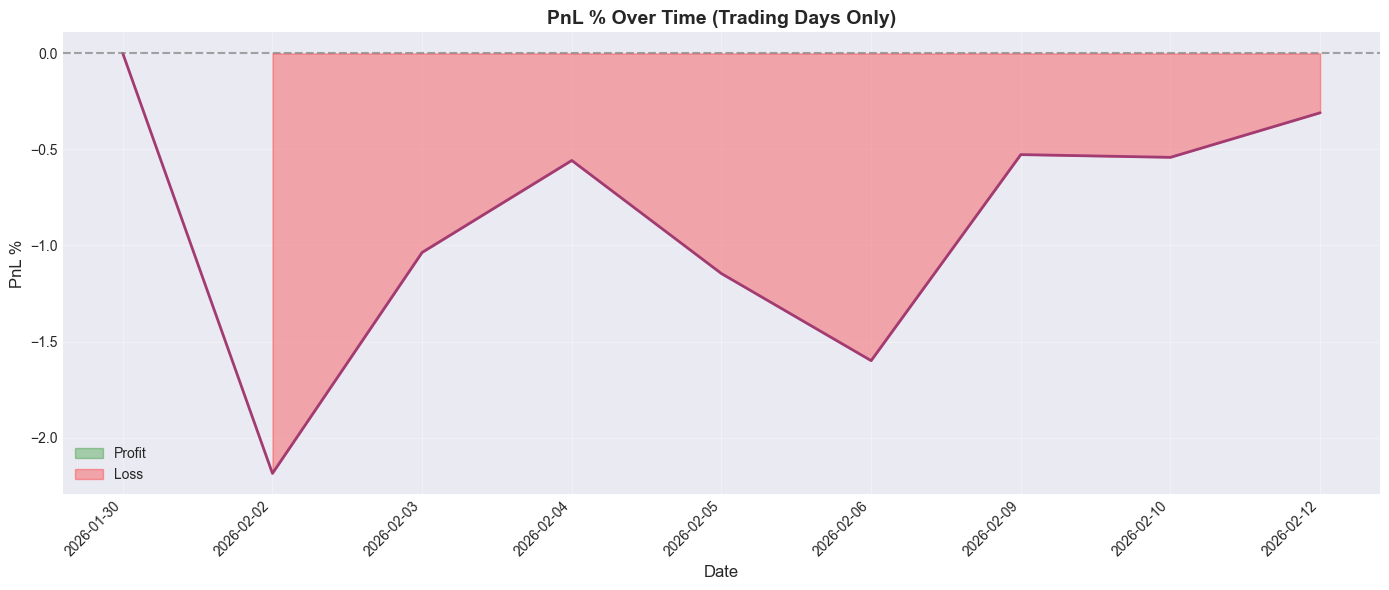

In [12]:
# Get PnL data
pnl_df = portfolio.pnl

if not pnl_df.empty:
    print_section("PnL Summary")
    print(f"\nEntry Date: {pnl_df.index[0].date()}")
    print(f"Latest Data: {pnl_df.index[-1].date()}")
    print(f"Days tracked: {len(pnl_df)}")
    
    print(f"\nTotal PnL: {format_currency(pnl_df['PnL'].iloc[-1])} ({pnl_df['PnL %'].iloc[-1]:+.2f}%)")
    
    if len(pnl_df) > 1:
        print(f"\nBest day: {format_currency(pnl_df['PnL'].max())} ({pnl_df['PnL %'].max():+.2f}%) on {pnl_df['PnL'].idxmax().date()}")
        print(f"Worst day: {format_currency(pnl_df['PnL'].min())} ({pnl_df['PnL %'].min():+.2f}%) on {pnl_df['PnL'].idxmin().date()}")
    
    print("\nRecent PnL:")
    print(pnl_df.tail(10).to_string(float_format=lambda x: f'{x:,.2f}'))
    
    # Plot PnL %
    print("\n")
    portfolio.plot_pnl()
else:
    print("No PnL data available (no trades yet)")

## 5. Performance Analysis

Comprehensive performance metrics including Sharpe, Sortino, max drawdown, etc.

In [13]:
# Get performance metrics
analysis = portfolio.analysis

if not analysis.empty:
    print_section("Performance Metrics")
    print()
    
    # Format metrics for display
    metrics_display = {
        'Total Return': f"{analysis.get('total_return', 0):.2f}%",
        'Absolute PnL': format_currency(analysis.get('absolute_pnl', 0)),
        'Annual Return': f"{analysis.get('annual_return', 0)*100:.2f}%",
        'Sharpe Ratio': f"{analysis.get('sharpe_ratio', 0):.2f}",
        'Sortino Ratio': f"{analysis.get('sortino_ratio', 0):.2f}",
        'Max Drawdown': f"{analysis.get('max_drawdown', 0)*100:.2f}%",
        'Calmar Ratio': f"{analysis.get('calmar_ratio', 0):.2f}",
        'Win Rate': f"{analysis.get('win_rate', 0)*100:.2f}%"
    }
    
    for metric, value in metrics_display.items():
        print(f"{metric:<20}: {value:>15}")
else:
    print("No analysis available (insufficient data)")


PERFORMANCE METRICS

Total Return        :          -0.31%
Absolute PnL        :            ¥-93
Annual Return       :          -9.30%
Sharpe Ratio        :           -0.72
Sortino Ratio       :           -0.82
Max Drawdown        :          -2.19%
Calmar Ratio        :           -4.25
Win Rate            :          50.00%


## 6. Trade Log

Full history of all trades with realized PnL tracking.

In [14]:
# Get trade log
trade_log = portfolio.log

if not trade_log.empty:
    print_section("Trade Log")
    print(f"\nTotal trades: {len(trade_log)}")
    print()
    
    # Format trade log for display
    print(trade_log.to_string(index=False, float_format=lambda x: f'{x:,.2f}'))
    
    # Summary stats
    total_commissions = trade_log['Commission'].sum()
    total_realized_pnl = trade_log['Realized PnL'].sum()
    
    print(f"\nTotal Commissions Paid: {format_currency(total_commissions)}")
    print(f"Total Realized PnL: {format_currency(total_realized_pnl)}")
else:
    print("No trades yet")


TRADE LOG

Total trades: 6

      Date       ETF Side  Shares  Price     Value  Commission  Realized PnL
2026-01-30 510300.SH  buy     700   4.68  3,276.70        0.98          0.00
2026-01-30 510500.SH  buy     300   8.36  2,509.20        0.75          0.00
2026-01-30 513500.SH  buy    1100   2.40  2,644.40        0.79          0.00
2026-01-30 511260.SH  buy     100 135.10 13,509.60        4.05          0.00
2026-01-30 518880.SH  buy     300  10.69  3,205.80        0.96          0.00
2026-01-30 513100.SH  buy    1100   1.84  2,027.30        0.61          0.00

Total Commissions Paid: ¥8
Total Realized PnL: ¥0


---

## Next Steps:

### If Rebalancing Needed:
1. Execute the trades shown in "Required Trades" section
2. Add new trades using `portfolio.trade()` method:
   ```python
   portfolio.trade(qty=100, price=4.50, side='buy', day='2026-02-12', etf='510300.SH')
   ```
3. Rerun notebook to see updated status

### Usage Examples:

**Add cash deposit:**
```python
portfolio.add_cash(10000)  # Add ¥10,000 to portfolio
```

**Execute buy trade:**
```python
portfolio.trade(qty=200, price=8.50, side='buy', day='2026-02-12', etf='510500.SH')
```

**Execute sell trade:**
```python
portfolio.trade(qty=100, price=2.40, side='sell', day='2026-02-12', etf='513500.SH')
```

### Rebalance Schedule:
- Check weekly (every Monday)
- Or when drift > 5%
- All ETFs trade in 100-share lots (automatically rounded)

### Data Updates:
- Prices auto-fetch from Yahoo Finance (yfinance)
- Falls back to local data if yfinance unavailable
- PnL tracks from first trade date to latest available data
- Cache refreshes every 1 hour